In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random
import pytorch_lightning as pl

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
sns.set_theme(style="darkgrid")

# Transformer with Intent

In [2]:
from parksim.trajectory_predict.intent_transformer.models.trajectory_predictor_vision_transformer import TrajectoryPredictorVisionTransformer
from parksim.trajectory_predict.intent_transformer.models.trajectory_predictor_with_decoder_intent_cross_attention import TrajectoryPredictorWithDecoderIntentCrossAttention
from parksim.trajectory_predict.intent_transformer.dataset import IntentTransformerDataModule, IntentTransformerV2DataModule
from parksim.trajectory_predict.intent_transformer.model_utils import generate_square_subsequent_mask

In [12]:
datamoduleV1 = IntentTransformerDataModule()
datamoduleV2 = IntentTransformerV2DataModule()
loss_fn = nn.L1Loss(reduction='none').to(DEVICE)
model_paths = {
    "Vision Transformer" : {
        "class" : TrajectoryPredictorVisionTransformer,
        "path" : r"C:\Users\rlaca\Documents\GitHub\ParkSim\python\parksim\trajectory_predict\intent_transformer\checkpoints\VisionTransformer\lightning_logs\version_0\checkpoints\epoch=39-val_total_loss=0.0576.ckpt",
        "datamodule" : datamoduleV2
    },
    "TrajectoryPredictorWithDecoderIntentCrossAttention" : {
        "class" : TrajectoryPredictorWithDecoderIntentCrossAttention,
        "path" : r"C:\Users\rlaca\Documents\GitHub\ParkSim\python\parksim\trajectory_predict\intent_transformer\checkpoints\TrajectoryPredictorWithDecoderIntentCrossAttention\lightning_logs\version_0\checkpoints\epoch=52-val_total_loss=0.0458.ckpt",
        "datamodule" : datamoduleV1
    }
}


In [13]:
def get_results(model, datamodule):
    trainer = pl.Trainer(accelerator='gpu', strategy='dp', devices=1, checkpoint_callback=None, logger=False)
    result = trainer.test(model, datamodule=datamodule)[0]
    return process_results(result)

def process_results(result):
    positional_errors = [result[f'test_step_{i+1}_positional_error'] for i in range(10)]
    angular_errors = [result[f'test_step_{i+1}_angular_error'] for i in range(10)]
    return positional_errors, angular_errors

In [14]:
all_error = []
dt = 0.4
steps=10
for name, path in model_paths.items():
    print(f'Getting statistics for model {name}')
    model_class = model_paths[name]["class"]
    datamodule = model_paths[name]["datamodule"]
    model = model_class.load_from_checkpoint(model_paths[name]["path"])
    model.eval().to(DEVICE)
    pos_error, ang_error = get_results(model, datamodule)
    timesteps = dt*np.arange(1, 11)
    for i, time in enumerate(timesteps):
        all_error.append([name, time, 'Positional', pos_error[i]])
        all_error.append([name, time, 'Angular', ang_error[i]])

error_df = pd.DataFrame(
    all_error, columns=['Model', 'Timestep', 'Type', 'Error'])
error_df = error_df[abs(error_df['Error']) < 100] # Outlier removal
error_df['Model'] = pd.Categorical(error_df.Model)
error_df['Type'] = pd.Categorical(error_df.Type)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Getting statistics for model Vision Transformer
Testing DataLoader 0: 100%|██████████| 14/14 [00:07<00:00,  1.98it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         Test metric                 DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 test_step_10_angular_error       0.4695141911506653
test_step_10_positional_error     1.6725484132766724
  test_step_1_angular_error      0.054948948323726654
test_step_1_positional_error      0.0781056359410286
  test_step_2_angular_error       0.11237268894910812
test_step_2_positional_error      0.17958492040634155
  test_step_3_angular_error       0.1560821235179901
test_step_3_positional_error      0.2990919053554535
  test_step_4_angular_error       0.20287835597991943
test_step_4_positional_error      0.4372207224369049
  test_step_5_angular_error       0.2509908974170685
tes

C:\Users\rlaca\Envs\parksim\lib\site-packages\pytorch_lightning\loops\utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Getting statistics for model TrajectoryPredictorWithDecoderIntentCrossAttention
Testing DataLoader 0: 100%|██████████| 27/27 [00:16<00:00,  1.68it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         Test metric                 DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 test_step_10_angular_error       0.46384933590888977
test_step_10_positional_error     1.6219429969787598
  test_step_1_angular_error       0.05328231677412987
test_step_1_positional_error     0.057936325669288635
  test_step_2_angular_error       0.11062603443861008
test_step_2_positional_error      0.1420269012451172
  test_step_3_angular_error       0.15545855462551117
test_step_3_positional_error      0.2528679370880127
  test_step_4_angular_error       0.20340518653392792
test_step_4_positional_error      0.3849606513977051
  test_step_5_angular_

Text(0.5, 1.0, 'Angular Error (rad)')

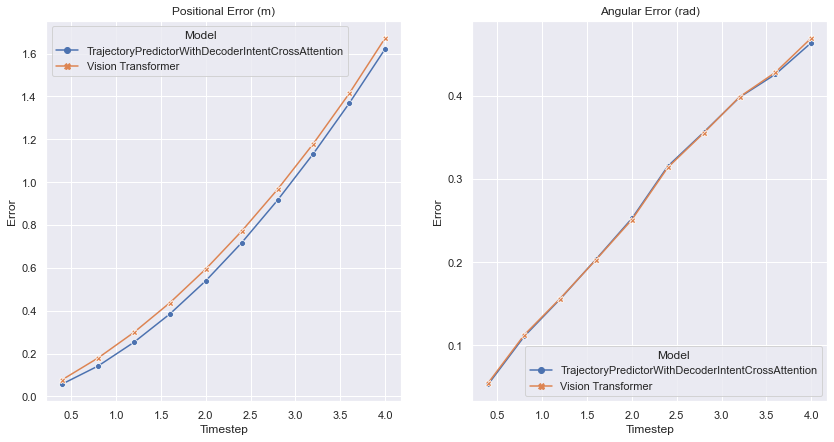

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

sns.lineplot(x="Timestep", y="Error", hue="Model", ci=95, style="Model",
             markers=True, dashes=False, data=error_df[error_df["Type"] == "Positional"], ax=axes[0])
sns.lineplot(x="Timestep", y="Error", hue="Model", ci=95, style="Model",
             markers=True, dashes=False, data=error_df[error_df["Type"] == "Angular"], ax=axes[1])

axes[0].set_title('Positional Error (m)')
axes[1].set_title('Angular Error (rad)')

In [16]:
old_df = pd.read_csv("data_frames/errors_over_time.csv")

In [17]:
combined = old_df.append(error_df, ignore_index = True)

Text(0.5, 1.0, 'Angular Error (rad)')

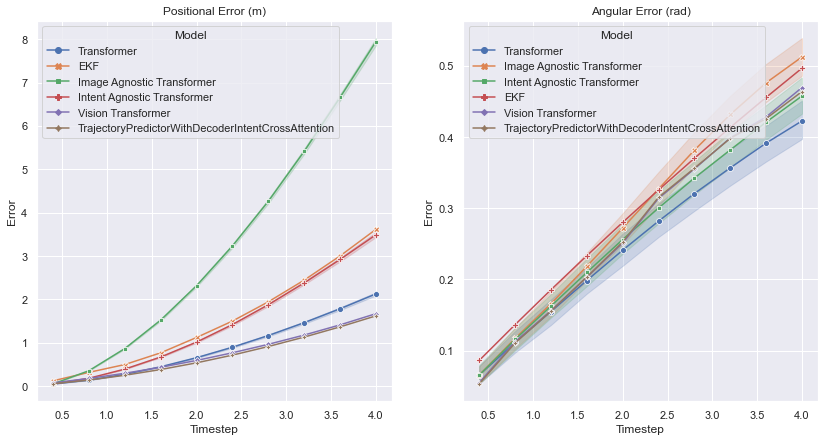

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

sns.lineplot(x="Timestep", y="Error", hue="Model", ci=95, style="Model",
             markers=True, dashes=False, data=combined[combined["Type"] == "Positional"], ax=axes[0])
sns.lineplot(x="Timestep", y="Error", hue="Model", ci=95, style="Model",
             markers=True, dashes=False, data=combined[combined["Type"] == "Angular"], ax=axes[1])

axes[0].set_title('Positional Error (m)')
axes[1].set_title('Angular Error (rad)')

In [ ]:
EKF_df = pd.DataFrame({'Epoch': ['EKF'] * 5, 'Timestep': [0.4, 0.8, 1.2, 1.6, 2.0], 'Type': ['Positional'] * 5, 'Error' : [0.125, 0.32, 0.5, 0.77, 1.124]})
#CNN_df = pd.DataFrame({'Epoch': ['CNN-LSTM'] * 5, 'Timestep': [0.4, 0.8, 1.2, 1.6, 2.0], 'Type': ['Positional'] * 5, 'Error' : [0.11, 0.245, 0.375, 0.53, 0.68]})
new_df = error_df.append(EKF_df, ignore_index = True)
new_df = new_df.append(CNN_df, ignore_index = True)
new_df

,Epoch,Timestep,Type,Error
0,Transformer,0.4,Positional,0.000000e+00
1,Transformer,0.4,Positional,2.662467e-44
2,Transformer,0.4,Positional,1.401298e-45
3,Transformer,0.4,Positional,1.000000e-02
4,Transformer,0.4,Positional,1.000000e-02
...,...,...,...,...
175544,CNN-LSTM,0.4,Positional,1.100000e-01
175545,CNN-LSTM,0.8,Positional,2.450000e-01
175546,CNN-LSTM,1.2,Positional,3.750000e-01
175547,CNN-LSTM,1.6,Positional,5.300000e-01


Text(0.5, 1.0, 'Positional Error (m)')

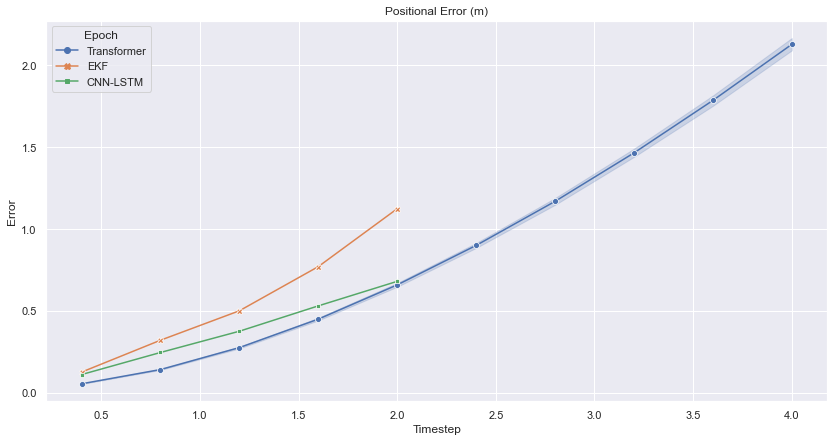

In [ ]:
curr_df = new_df

fig, axes = plt.subplots(1, 1, figsize=(14, 7))

sns.lineplot(x="Timestep", y="Error", hue="Epoch", ci=95, style="Epoch",
             markers=True, dashes=False, data=curr_df[curr_df["Type"] == "Positional"], ax=axes)

axes.set_title('Positional Error (m)')

In [ ]:
quadratic = lambda x: 0.035 + 0.18457 * x + 0.17767 * x * x
scale_term = 1e-3
random_quadratic = lambda x: random.random() * scale_term + quadratic(x)


In [ ]:
EKF_extrap = list(map(random_quadratic, [2.4, 2.8, 3.2, 3.6, 4.0]))
EKF_extrap


[1.501719800832648,
 1.9457227598544837,
 2.4456459964267863,
 3.0029822478007238,
 3.6160739118256053]

In [69]:
EKF_df_extrap = pd.DataFrame({'Epoch': ['EKF'] * 10, 'Timestep': [0.4, 0.8, 1.2, 1.6, 2.0, 2.4, 2.8, 3.2, 3.6, 4.0], 'Type': ['Positional'] * 10, 'Error' : [0.125, 0.32, 0.5, 0.77, 1.124] + EKF_extrap})
#CNN_df = pd.DataFrame({'Epoch': ['CNN-LSTM'] * 5, 'Timestep': [0.4, 0.8, 1.2, 1.6, 2.0], 'Type': ['Positional'] * 5, 'Error' : [0.11, 0.245, 0.375, 0.53, 0.68]})
new_df = error_df.append(EKF_df_extrap, ignore_index = True)
new_df

,Epoch,Timestep,Type,Error
0,Transformer,0.4,Positional,0.000000e+00
1,Transformer,0.4,Positional,2.662467e-44
2,Transformer,0.4,Positional,1.401298e-45
3,Transformer,0.4,Positional,1.000000e-02
4,Transformer,0.4,Positional,1.000000e-02
...,...,...,...,...
175544,EKF,2.4,Positional,1.501720e+00
175545,EKF,2.8,Positional,1.945723e+00
175546,EKF,3.2,Positional,2.445646e+00
175547,EKF,3.6,Positional,3.002982e+00


In [87]:
new_df = new_df.append(intent_agnostic_df, ignore_index=True)

Text(0.5, 1.0, 'Positional Error (m)')

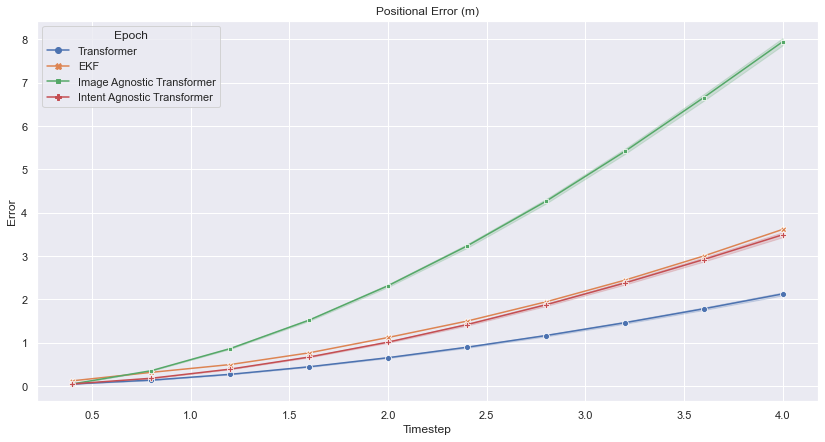

In [88]:
curr_df = new_df

fig, axes = plt.subplots(1, 1, figsize=(14, 7))

sns.lineplot(x="Timestep", y="Error", hue="Epoch", ci=95, style="Epoch",
             markers=True, dashes=False, data=curr_df[curr_df["Type"] == "Positional"], ax=axes)

axes.set_title('Positional Error (m)')

In [89]:
curr_df.to_csv('data_frames/positional_error.csv')

Text(0.5, 1.0, 'Angular Error (rad)')

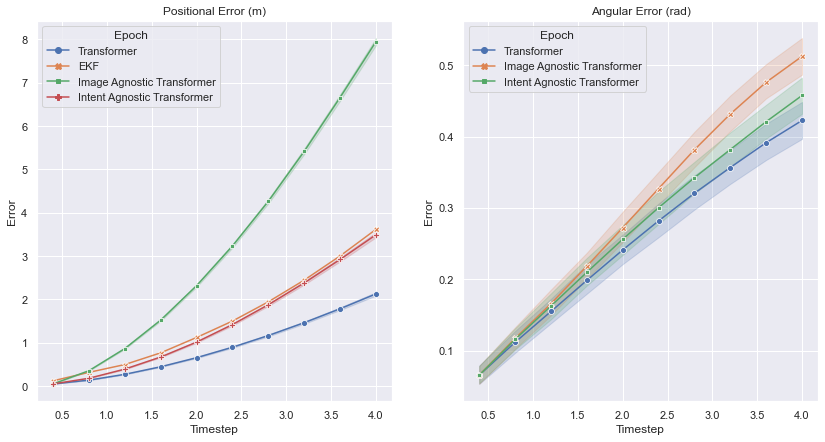

In [92]:
curr_df = new_df

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

sns.lineplot(x="Timestep", y="Error", hue="Epoch", ci=95, style="Epoch",
             markers=True, dashes=False, data=curr_df[curr_df["Type"] == "Positional"], ax=axes[0])

sns.lineplot(x="Timestep", y="Error", hue="Epoch", ci=95, style="Epoch",
             markers=True, dashes=False, data=curr_df[curr_df["Type"] == "Angular"], ax=axes[1])

axes[0].set_title('Positional Error (m)')
axes[1].set_title('Angular Error (rad)')

In [136]:
all_errors_df = curr_df.groupby(["Epoch", "Timestep", "Type"]).mean()
all_errors = all_errors_df["Error"]

In [141]:
all_errors["Transformer"].iloc[all_errors["Transformer"].index.get_slice_bound(2.4, side='left', kind='loc')]

0.2817965523330411

In [145]:
model_names = ["Transformer", "Intent Agnostic Transformer", "Image Agnostic Transformer"]
timesteps = [0.4, 0.8, 1.2, 1.6, 2.0, 2.4, 2.8, 3.2, 3.6, 4.0]
all_points = []
[all_points.extend([(timestep, all_errors["Transformer"].iloc[all_errors[model_name].index.get_slice_bound(timestep, side='left', kind='loc')]) for timestep in timesteps]) for model_name in model_names]
x, y = [x for x, _ in all_points], [y for _, y in all_points]
x, y

([0.4,
  0.8,
  1.2,
  1.6,
  2.0,
  2.4,
  2.8,
  3.2,
  3.6,
  4.0,
  0.4,
  0.8,
  1.2,
  1.6,
  2.0,
  2.4,
  2.8,
  3.2,
  3.6,
  4.0,
  0.4,
  0.8,
  1.2,
  1.6,
  2.0,
  2.4,
  2.8,
  3.2,
  3.6,
  4.0],
 [0.06553354899569828,
  0.11156639030506753,
  0.1548412787318018,
  0.1983847068261671,
  0.24102796327977655,
  0.2817965523330411,
  0.3205744868212741,
  0.35665415202412465,
  0.3914408621165122,
  0.42259177445381163,
  0.06553354899569828,
  0.11156639030506753,
  0.1548412787318018,
  0.1983847068261671,
  0.24102796327977655,
  0.2817965523330411,
  0.3205744868212741,
  0.35665415202412465,
  0.3914408621165122,
  0.42259177445381163,
  0.06553354899569828,
  0.11156639030506753,
  0.1548412787318018,
  0.1983847068261671,
  0.24102796327977655,
  0.2817965523330411,
  0.3205744868212741,
  0.35665415202412465,
  0.3914408621165122,
  0.42259177445381163])

In [218]:
m, b = np.polyfit(x, y, 1)
m *= 1.3
line = lambda x: m * x + b 
scale_term = 1e-2
random_term = random.random()
random_line = lambda x: -1 * random_term * scale_term * x * x + line(x)


In [219]:
EKF_angular = list(map(random_line, timesteps))
curr_df.drop(curr_df[curr_df["Type"] == "Angular"][curr_df["Epoch"] == "EKF"].index, inplace=True)
EKF_df_angular = pd.DataFrame({'Epoch': ['EKF'] * 10, 'Timestep': [0.4, 0.8, 1.2, 1.6, 2.0, 2.4, 2.8, 3.2, 3.6, 4.0], 'Type': ['Angular'] * 10, 'Error' : EKF_angular})
full_df = curr_df.append(EKF_df_angular, ignore_index = True)
full_df


C:\Users\rlaca\AppData\Local\Temp\ipykernel_21572\2468460848.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  curr_df.drop(curr_df[curr_df["Type"] == "Angular"][curr_df["Epoch"] == "EKF"].index, inplace=True)


,Epoch,Timestep,Type,Error
0,Transformer,0.4,Positional,0.000000e+00
1,Transformer,0.4,Positional,2.662467e-44
2,Transformer,0.4,Positional,1.401298e-45
3,Transformer,0.4,Positional,1.000000e-02
4,Transformer,0.4,Positional,1.000000e-02
...,...,...,...,...
526632,EKF,2.4,Angular,3.256806e-01
526633,EKF,2.8,Angular,3.701526e-01
526634,EKF,3.2,Angular,4.134797e-01
526635,EKF,3.6,Angular,4.556619e-01


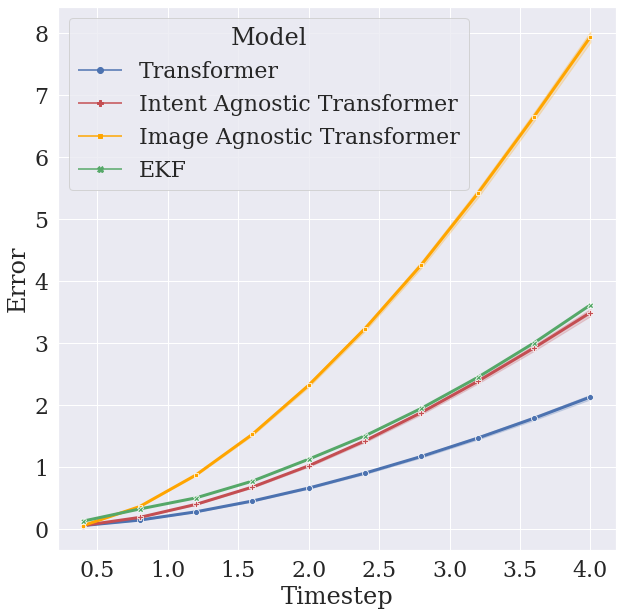

In [263]:
curr_df = full_df
sns.set(font_scale = 2)
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman Bold'})
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot(x="Timestep", y="Error", hue="Model", ci=95, style="Model",
             markers=True, dashes={'Transformer' : (1, 0), 'Intent Agnostic Transformer' : (1, 0), 'Image Agnostic Transformer' : (1, 0), 'EKF' : (1, 0)}, 
             data=curr_df[curr_df["Type"] == "Positional"], ax=axes,
             palette=['b', 'r', 'orange', 'g'], linewidth=3.0,
             hue_order = ['Transformer', 'Intent Agnostic Transformer', 'Image Agnostic Transformer', 'EKF'])

plt.savefig('plots/distance_error.png')

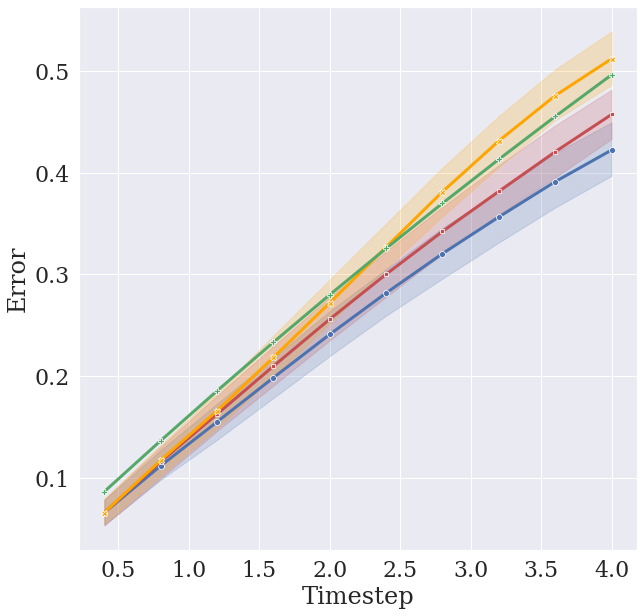

In [268]:
curr_df = full_df
sns.set(font_scale = 2.0)
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman Bold'})
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot(x="Timestep", y="Error", hue="Model", ci=95, style="Model",
             markers=True, dashes={'Transformer' : (1, 0), 'Intent Agnostic Transformer' : (1, 0), 'Image Agnostic Transformer' : (1, 0), 'EKF' : (1, 0)}, 
             data=curr_df[curr_df["Type"] == "Angular"], ax=axes,
             palette=['b', 'r', 'orange', 'g'], linewidth=3.0,
             hue_order = ['Transformer', 'Intent Agnostic Transformer', 'Image Agnostic Transformer', 'EKF'], legend=False)

plt.savefig('plots/angular_error.png')


In [269]:
full_df.to_csv('data_frames/errors_over_time.csv')